In [4]:
import sys

import pandas as pd

sys.path.append('../src/construct/')
import util
idx = pd.IndexSlice

In [45]:
vehicle_kms = pd.read_csv(
    'https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_tf_veh.tsv.gz',
    delimiter='\t', index_col=0
)
vehicle_kms.index = vehicle_kms.index.str.split(',', expand=True).rename(['reg_type', 'unit', 'vehicle', 'country_code'])
vehicle_kms = vehicle_kms.apply(util.to_numeric)

vehicle_types = {
    'TOTAL': ('Total', 'total'),
    'LOR': ('lorries', 'diesel'),
    'LOR_LE3P5': ('lorries_small', 'diesel'),
    'LOR_GT3P5-6': ('lorries_medium', 'diesel'),
    'LOR_GT6': ('lorries_big', 'diesel'),
    'TRC': 	('tractors', 'diesel'),
    'MOTO_MOP': ('motorcycles', 'diesel'),
    'CAR': ('passenger_cars', 'total'),
    'CAR_PET': ('passenger_cars', 'petrol'),
    'CAR_DIE': ('passenger_cars', 'diesel'),
    'CAR_OTH': ('passenger_cars', 'other'),
    'BUS_TOT': 	('buses', 'diesel'),
    'MTZ_OTH': 	('other', 'other')
}

In [46]:
vehicle_kms = (
    vehicle_kms
    .xs(('D005', 'MIO_VKM'))
    .unstack('country_code')
)
vehicle_kms.index = vehicle_kms.index.map(vehicle_types)
vehicle_kms= vehicle_kms.groupby(level=0).sum(min_count=1)
vehicle_kms.index = pd.MultiIndex.from_tuples(vehicle_kms.index).rename(['vehicle', 'carrier'])

# Rail profiles

In [122]:
profiles.columns

Index(['0.00', '1.00', '2.00', '3.00', '4.00', '5.00', '6.00'], dtype='object')

In [161]:
profiles = pd.read_csv('../data/transport/rail_daily_profiles_destinee.csv', index_col=0, header=0)
profiles.columns = profiles.columns.astype(float)
profiles.index = profiles.index.astype(float)

In [162]:
profiles

,0.0,1.0,2.0,3.0,4.0,5.0,6.0
0.0,0.012301,0.012301,0.012301,0.012301,0.012301,0.013967,0.011315
1.0,0.002083,0.002083,0.002083,0.002083,0.002083,0.002962,0.007926
2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001189,0.004461
3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001791
4.0,0.002609,0.002609,0.002609,0.002609,0.002609,0.002962,0.001791
5.0,0.013212,0.013212,0.013212,0.013212,0.013212,0.008053,0.004461
6.0,0.049384,0.049384,0.049384,0.049384,0.049384,0.015501,0.009630
7.0,0.070758,0.070758,0.070758,0.070758,0.070758,0.031298,0.019463
8.0,0.074476,0.074476,0.074476,0.074476,0.074476,0.051108,0.030122
9.0,0.069557,0.069557,0.069557,0.069557,0.069557,0.064848,0.044590


In [277]:
rail_profile = pd.Series(index=pd.date_range('2016', '2017', freq='1H'))

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


2016-01-01 00:00:00   NaN
2016-01-01 01:00:00   NaN
2016-01-01 02:00:00   NaN
2016-01-01 03:00:00   NaN
2016-01-01 04:00:00   NaN
                       ..
2016-12-31 19:00:00   NaN
2016-12-31 20:00:00   NaN
2016-12-31 21:00:00   NaN
2016-12-31 22:00:00   NaN
2016-12-31 23:00:00   NaN
Freq: H, Length: 8784, dtype: float64

In [183]:
annual_profiles = pd.merge(
    rail_profile.groupby([rail_profile.index.date, rail_profile.index.hour, rail_profile.index.dayofweek]).sum().rename_axis(index=['date', 'hour', 'dayofweek']).rename('delete_me'), 
    profiles.dropna(axis=1).stack().rename_axis(index=['hour', 'dayofweek']).rename('profiles'),
    left_index=True, right_index=True
).drop('delete_me', axis=1)
annual_profiles.index = pd.to_datetime(annual_profiles.index.get_level_values('date')) + pd.to_timedelta(annual_profiles.index.get_level_values('hour').astype(int), unit='h')
annual_profiles = annual_profiles.sort_index()

In [184]:
annual_profiles

,profiles
2016-01-01 00:00:00,0.012301
2016-01-01 01:00:00,0.002083
2016-01-01 02:00:00,0.000000
2016-01-01 03:00:00,0.000000
2016-01-01 04:00:00,0.002609
...,...
2016-12-31 19:00:00,0.055804
2016-12-31 20:00:00,0.046476
2016-12-31 21:00:00,0.035362
2016-12-31 22:00:00,0.032131


In [139]:
import pytz

In [179]:
def _shift_profiles(profile, country, model_year):
    """
    Shift profiles forward/backward in time based on region timezones
    """
    tz = pytz.country_timezones[country][0]
    try:
        idx = profile.index.tz_localize(tz, nonexistent='shift_forward').tz_convert('UTC')
    except pytz.AmbiguousTimeError as err:
        idx = profile.index.tz_localize(
            tz, ambiguous=profile.index != err.args[0], nonexistent='shift_forward'
        ).tz_convert('UTC')
    shift = len(idx[idx.year > model_year]) - len(idx[idx.year < model_year])
    profile = np.roll(profile, shift=shift)
    return profile

In [185]:
for i in ['PT', 'GB', 'DE', 'GR']:
    annual_profiles[i] = _shift_profiles(annual_profiles['profiles'], i, 2016)


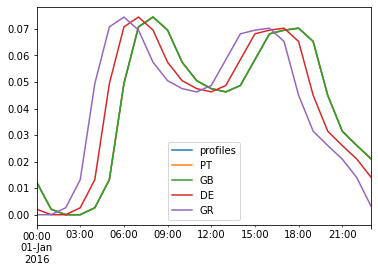

In [187]:
annual_profiles.iloc[0:24].plot()

In [151]:
import numpy as np

In [210]:
pd.read_csv("../build/annual_industry_energy_demand.csv"), index_col=[0, 1, 2, 3, 4, 5, 6], squeeze=True).sum(level=['carrier', 'vehicle_type', 'country_code', 'year']).xs('electricity')

,subsector,country_code,unit,carrier,year,0
0,Iron and steel,FR,twh,electricity,1950.0,26.227661
1,Iron and steel,FR,twh,electricity,1960.0,26.227661
2,Iron and steel,FR,twh,electricity,1970.0,26.227661
3,Iron and steel,FR,twh,electricity,1978.0,26.227661
4,Iron and steel,FR,twh,electricity,1979.0,26.227661
...,...,...,...,...,...,...
56695,Wood and wood products,RS,twh,space_heating,2015.0,0.007534
56696,Wood and wood products,RS,twh,space_heating,2016.0,0.002053
56697,Wood and wood products,RS,twh,space_heating,2017.0,0.002053
56698,Wood and wood products,RS,twh,space_heating,2018.0,0.002053


In [239]:
energy_balances = pd.read_csv('../build/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [294]:
energy_balances.xs(('FC_TRA_ROAD_E', 'TOTAL')).unstack()#, level='carrier_code').unstack(['unit', 'country', 'year']).groupby(cat_names).sum(min_count=1).rename_axis(index='cat_name').stack(['unit', 'country']).bfill(axis=1).stack()

year               1990.0       1991.0       1992.0       1993.0       1994.0  \
unit country                                                                    
TJ   AL          9768.800     7392.400     5686.800     7102.800     8966.000   
     AT        178878.720   198388.228   198623.799   202962.227   203456.263   
     BA               NaN          NaN          NaN          NaN          NaN   
     BE        269238.200   271740.800   282065.600   288732.400   295330.600   
     BG         82734.300    45628.900    49723.800    56328.400    52385.400   
     CY         16250.900    16217.000    18197.600    18451.700    19197.000   
     CZ         96201.540    85580.704   107411.554   108669.174   118696.589   
     DE       2131794.900  2178389.700  2222703.600  2286433.400  2248371.000   
     DK        128516.800   133592.900   135816.200   137491.600   144261.500   
     EE         30876.760    28102.760    13439.279    14580.325    17799.690   
     EL        165108.900   176759.200   181105.200   185326.700   187908.500   
     ES        748838.300   789394.200   835359.200   824077.300   856062.500   
     FI        151934.800   147810.700   147520.100   143670.000   148582.300   
     FR       1532690.700  1569554.700  1603059.100  1614500.900  1635526.900   
     HR         45452.240    35760.890    34239.310    36709.380    39745.360   
     HU        109065.100    97791.300    95308.500    95947.000    93564.700   
     IE         65858.925    68439.717    74331.383    73958.013    77119.748   
     IS          7656.200     7920.700     7829.500     7828.200     8004.100   
     IT       1295093.500  1322739.600  1395236.800  1424921.600  1423154.700   
     LT         72392.410    80200.500    51313.150    38189.250    28652.350   
     LU         36145.017    42982.448    46994.963    47591.436    48455.310   
     LV         33824.760    31338.830    28555.250    28108.140    26912.180   
     ME               NaN          NaN          NaN          NaN          NaN   
     MK         10572.300    10660.900    10660.900    18553.300    13159.900   
     NL        360470.564   365990.940   386243.512   397768.224   389342.304   
     NO        108790.200   113906.100   115591.900   121084.200   120357.700   
     PL        252535.800   273825.100   284684.900   279132.200   292976.600   
     PT        129402.630   139571.390   152582.360   160663.160   168804.860   
     RO        151434.700   127885.400   116201.600    97217.100   106048.900   
     RS         62164.600    44397.000    31390.200    37421.400    36385.000   
     SE        256716.400   254328.600   264433.300   260486.000   270622.800   
     SI         36854.500    34739.800    35756.000    43336.700    48466.500   
     SK         56421.080    46861.320    49113.640    40719.360    46548.360   
     UK       1535057.600  1523972.300  1543825.200  1560491.800  1567289.900   

year               1995.0       1996.0       1997.0       1998.0       1999.0  \
unit country                                                                    
TJ   AL          8901.200     8820.400     7040.000    10388.000    17105.600   
     AT        206817.306   228512.230   215705.486   242417.498   235010.159   
     BA               NaN          NaN          NaN          NaN          NaN   
     BE        296329.200   301706.600   304859.600   314091.600   318014.000   
     BG         56574.300    56666.000    57147.500    70910.700    73315.100   
     CY         20361.900    21053.800    21963.300    23000.500    23612.900   
     CZ        101590.038   133880.368   137693.436   140613.745   157783.694   
     DE       2283342.300  2303167.400  2316753.100  2362050.100  2432941.600   
     DK        145477.200   147889.300   150937.700   153640.100   155598.000   
     EE         17880.355    19469.720    20365.885    21212.650    21071.480   
     EL        193945.200   203302.800   208035.900   218465.900   222339.500   
     ES        867456.400   92

In [317]:
len(['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK',
       'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'UK'])

34

In [316]:
foo.reindex(set_index().set_index([i for i in foo.reset_index().columns[:-1]]).squeeze()#index.levels[-1].duplicated()

cat_code   unit  country  year  
AFC        TJ    AL       1990.0     6408.000
                          1991.0     4827.600
                          1992.0     5198.400
                          1993.0     6109.200
                          1994.0     6750.000
                                      ...    
TO_EHG_PH  TJ    UK       2014.0    10380.541
                          2015.0     9861.898
                          2016.0    10653.174
                          2017.0    10339.308
                          2018.0     8994.420
Name: 0, Length: 60036, dtype: float64

Index(['ALB', 'AUT', 'BEL', 'BGR', 'BIH', 'CHE', 'CYP', 'CZE', 'DEU', 'DNK',
       'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ISL',
       'ITA', 'LTU', 'LUX', 'LVA', 'MKD', 'MLT', 'MNE', 'NLD', 'NOR', 'POL',
       'PRT', 'ROU', 'SRB', 'SVK', 'SVN', 'SWE'],
      dtype='object', name='country_code')

In [332]:
pd.read_csv('../build/annual_industry_energy_demand.csv', index_col=[0, 1, 2, 3], squeeze=True)#.reindex(pd.read_csv('../build/annual_road_transport_distance_demand.csv', index_col=[0, 1, 2, 3], squeeze=True).index.levels[1], level='country_code').index.levels[1])

year          0
subsector              country_code unit carrier                         
Iron and steel         FR           twh  electricity    1950.0  28.846349
                                         electricity    1960.0  28.846349
                                         electricity    1970.0  28.846349
                                         electricity    1978.0  28.846349
                                         electricity    1979.0  28.846349
...                                                        ...        ...
Wood and wood products RS           twh  space_heating  2015.0   0.007534
                                         space_heating  2016.0   0.004665
                                         space_heating  2017.0   0.005336
                                         space_heating  2018.0   0.003134
                                         space_heating  2019.0   0.001586

[56700 rows x 2 columns]

In [278]:
pd.read_csv('../build/model/eurospores/annual_demand.csv')#

FileNotFoundError: [Errno 2] File ../build/model/eurospores/annual_demand.csv does not exist: '../build/model/eurospores/annual_demand.csv'